In [1]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

## Preprocessing

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {
            SOS_token: 'SOS',
            EOS_token: 'EOS'
        }
        self.n_words = len(self.index2word)
        
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

In [3]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r'([.!?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?]', r' ', s)
    return s

In [4]:
def readLangs(lang1, lang2, reverse=False):
    print('Reading lines...')
    lines = open(f'_data/{lang1}-{lang2}.txt', encoding='utf-8').\
                                    read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    
    return input_lang, output_lang, pairs

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    'i am', 'i m',
    'he is', 'he s',
    'she is', 'she s',
    'you are', 'you re',
    'we are', 'we re',
    'they are', 'they re'
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
           len(p[1].split(' ')) < MAX_LENGTH and \
           p[1].startswith(eng_prefixes)
        
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print(f'Read {len(pairs)} sentence pairs')
    pairs = filterPairs(pairs)
    print(f'Trimmed to {len(pairs)} sentence pairs')
    print('Counting words...')
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print('Counted words:')
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [7]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

Reading lines...
Read 145437 sentence pairs
Trimmed to 12201 sentence pairs
Counting words...
Counted words:
fra 4999
eng 3282


In [8]:
print(random.choice(pairs))

['elles ne sont pas du tout interessees .', 'they are not at all interested .']


## Seq2Seq

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
    
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden
    
    def initHidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size))

In [31]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def initHidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size))        

In [32]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
            encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
            
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden
    
    def initHidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size))        

In [21]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return Variable(torch.LongTensor(indexes).view(-1, 1))

def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [44]:
teacher_forcing_ratio = 0.5

def train(input_variable, target_variable, encoder, decoder, 
        encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    
    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]
        
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]
            
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]]))
            
            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break
                
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length
            
            

## Experiment

In [50]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {s}s'

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return f'{asMinutes(s)} (- {asMinutes(rs)})'

In [46]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
sns.set()

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [47]:
def trainIters(encoder, decoder, n_iters, print_every=1000, 
               plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs)) \
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]
        
        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer,
                     criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'{timeSince(start, iter / n_iters)} ({iter} {iter / n_iters * 100}%) {print_loss_avg:.4}')

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    showPlot(plot_losses)

In [48]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
                               1, dropout_p=0.1)

6 6.990113258361816 (- 85 37.86158561706543) (5000 6.666666666666667%) 3.072
12 17.098862648010254 (- 79 51.14260721206665) (10000 13.333333333333334%) 2.489
18 26.68960404396057 (- 73 46.758416175842285) (15000 20.0%) 2.171
24 38.54148578643799 (- 67 45.98908591270447) (20000 26.666666666666668%) 1.912
30 51.801029920578 (- 61 43.602059841156006) (25000 33.33333333333333%) 1.721
37 3.0887091159820557 (- 55 34.63306367397308) (30000 40.0%) 1.559
43 16.91284966468811 (- 49 27.90039961678667) (35000 46.666666666666664%) 1.408
49 29.084473133087158 (- 43 17.948913991451263) (40000 53.333333333333336%) 1.297
55 39.21403121948242 (- 37 6.142687479655251) (45000 60.0%) 1.155
61 49.054957151412964 (- 30 54.52747857570648) (50000 66.66666666666666%) 1.088
67 59.90372014045715 (- 24 43.60135277834888) (55000 73.33333333333333%) 0.9742
74 11.410367250442505 (- 18 32.852591812610626) (60000 80.0%) 0.9157
80 22.760148525238037 (- 12 21.963099773113754) (65000 86.66666666666667%) 0.8297
86 34.85960

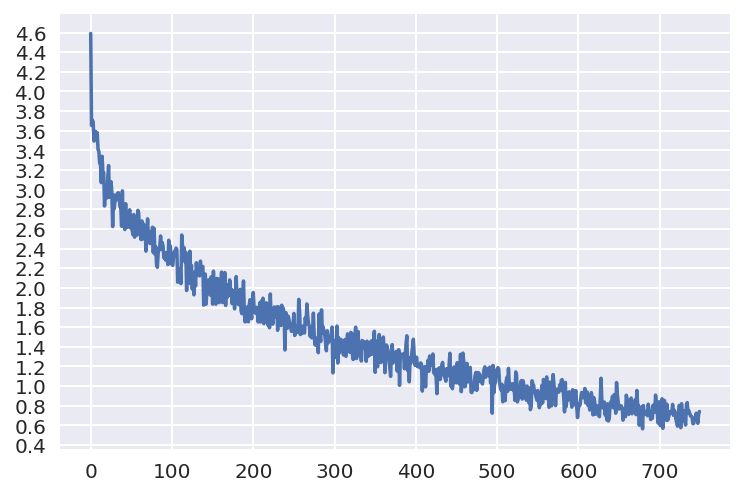

In [49]:
trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [58]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))

    return decoded_words, decoder_attentions[:di + 1]

In [59]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")